In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Carregar o conjunto de dados
data = pd.read_csv('data.csv').rename(columns={'Unnamed: 0': 'breed'})

# Pré-processamento dos dados

A partir de uma análise rápida do dataset fornecido, foram removidos alguns atributos, sendo esses:

- **Breed**: O atributo referente ao nome das raças dos cachorros não foi julgado como necessário para o modelo, pois utiliza etiquetas únicas para cada raça, possivelmente detrimental ao modelo.

- **Demeanor_category**, **Energy_level_category**, **Grooming_frequency_category**, **Shedding_category** e **Trainability_category**: Há uma redundância com outros atributos (Seus correspondentes em numéricos '_values'), tornando-os desnecessários.

- **Description**: O objetivo final não está relacionado com Processamento de Linguagem Natural, tornando o atributo irrelevante e custoso, uma vez que haveria uma complexidade maior em sua utilzação.

- **Popularity**: 28.52% (79/277) da amostra precisaria ser removida ou preenchida de forma apropriada pois a coluna apresenta muitos valores 'NaN' (Not a number).

- **Temperament**: Assim como no atributo 'description', existe uma subjetividade no atributo, o que inviabiliza o uso dele na criação do modelo.

In [3]:
#Visualizar a quantidade de NaN (Not a Number) por coluna
nan_count = data.isna().sum()
print(nan_count)

breed                           0
description                     0
temperament                     1
popularity                     79
min_height                      0
max_height                      0
min_weight                      2
max_weight                      2
min_expectancy                  3
max_expectancy                  3
group                           0
grooming_frequency_value        7
grooming_frequency_category     7
shedding_value                 20
shedding_category              20
energy_level_value              6
energy_level_category           6
trainability_value             24
trainability_category          24
demeanor_value                 25
demeanor_category              25
dtype: int64


In [4]:
data.drop(columns=["breed", "description", "temperament", "popularity", "grooming_frequency_category", "shedding_category", "energy_level_category", "trainability_category", "demeanor_category"], axis=1, inplace=True)

data.describe()

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
count,277.000000,277.000000,275.000000,275.000000,274.000000,274.000000,270.000000,257.000000,271.000000,253.000000,252.000000
mean,44.225801,52.720588,17.888858,27.291416,11.306569,13.832117,0.425926,0.529183,0.712915,0.624506,0.620635
std,14.238298,15.885454,12.290600,19.061416,1.817949,2.016668,0.198306,0.189068,0.168927,0.247271,0.201713
min,12.700000,17.780000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000
25%,33.020000,38.100000,8.164663,12.927383,10.000000,13.000000,0.200000,0.400000,0.600000,0.400000,0.400000
50%,45.085000,53.340000,15.875733,24.947580,12.000000,14.000000,0.400000,0.600000,0.600000,0.600000,0.600000
75%,55.880000,66.040000,22.679619,34.019428,12.000000,15.000000,0.600000,0.600000,0.800000,0.800000,0.800000
max,76.200000,88.900000,68.038855,108.862169,16.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Limpeza e tratamento de dados

#### Removendo incoerências

Processo é realizado para evitar inconsistências nos dados, aumentar a confiabilidade e qualidade do resultado a fim de um melhor desempenho dos modelos.

Desse modo, a partir de análise do dataset é possível afirmar que é incoerente dizer que:

1 - O máximo ou mínimo de peso, altura ou expectativa de vida é menor ou igual a 0.0 (Exemplo: **Cane Corso** -> Peso máx. e min. colocado como 0.0 no DataFrame).

2 - Ter linhas em que o mínimo de peso, altura ou expectitativa de vida sejam maiores que os seus respectivos máximos.

Além disso as linhas duplicadas no dataset também serão descartadas.

In [5]:
# max_height maior que zero + max_height maior que min_height + min_height maior que zero
heightFixed = ((data['max_height'] > 0.00) & (data['max_height'] >= data['min_height']) & (data['min_height'] > 0.00))
data = data[heightFixed]

# max_weight maior que zero + max_weight maior que min_weight + min_weight maior que zero
weightFixed = ((data['max_weight'] > 0.00) & (data['max_weight'] >= data['min_weight']) & (data['min_weight'] > 0.00))
data = data[weightFixed]

# max_expectancy maior que zero + max_expectancy maior que min_expectancy + min_expectancy maior que zero
expectancyFixed = ((data['max_expectancy'] > 0.00) & (data['max_expectancy'] >= data['min_expectancy']) & (data['min_expectancy'] > 0.00))
data = data[expectancyFixed]

# Retirando duplicados
data.drop_duplicates()

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
0,22.86,29.21,3.175147,4.535924,12.0,15.0,Toy Group,0.6,0.6,0.6,0.8,1.0
1,63.50,68.58,22.679619,27.215542,12.0,15.0,Hound Group,0.8,0.2,0.8,0.2,0.2
2,58.42,58.42,22.679619,31.751466,11.0,14.0,Terrier Group,0.6,0.4,0.6,1.0,0.8
3,60.96,71.12,31.751466,58.967008,10.0,13.0,Working Group,0.8,0.6,0.8,1.0,0.6
4,58.42,63.50,34.019428,38.555351,10.0,14.0,Working Group,0.6,0.6,0.8,0.4,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...
272,54.61,63.50,20.411657,29.483504,12.0,14.0,Sporting Group,0.2,0.6,0.8,0.6,0.6
273,48.26,63.50,12.700586,27.215542,12.0,15.0,Foundation Stock Service,0.2,0.6,0.8,0.4,0.6
274,25.40,58.42,4.535924,24.947580,13.0,18.0,Non-Sporting Group,0.2,0.2,0.8,0.6,0.6
275,53.34,58.42,18.143695,24.947580,10.0,12.0,Foundation Stock Service,0.4,0.6,0.8,0.2,0.4


### Tratamento de valores ausentes

No caso de dados ausentes, devido ao fato de ser um dataset pequeno, ao invés de remover as instâncias, foi decidido que seria melhor preenchê-las.

Foi utilizado o algoritmo **KNN**, uma vez que possui um melhor desempenho em comparação com métodos simples (Valores fixos), levando em consideração a estrutura e a relação dos dados, fornecendo estimativas mais precisas. Outros métodos como o método de regressão linear seriam mais úteis se existisse correlação entre as variáveis e padrões nos dados. Do mesmo modo, a regressão de árvore de decisão seria mais adequada para captura de relações complexas entre as variáveis de entrada com a variável alvo e conjuntos de dados grandes.

Para assegurar que pelo menos um valor irá se repetir, declarou-se K = 7.

Com relação ao 'group', já que ele será a saída escolhida, foi feita uma checagem para a existência de linhas que são NaN, que foram retiradas.

In [6]:
# Eliminando da coluna as linhas que o atributo for NaN
data['group'].replace('', np.nan, inplace=True)
data.dropna(subset=['group'], inplace=True)

# Atributos que terão espaços preenchidos
atributes = ["min_height", "max_height", "min_weight", "max_weight", "min_expectancy", "max_expectancy", "grooming_frequency_value", "shedding_value", "energy_level_value", "trainability_value", "demeanor_value"]

# Instanciar o imputador KNN
imputer = KNNImputer(n_neighbors=5, weights ="distance")

# Preencher os valores faltantes com base nos vizinhos mais próximos
data[atributes] = imputer.fit_transform(data[atributes])

# Verificar se há valores faltantes
value_null = data[atributes].isnull().sum()
print(value_null)

min_height                  0
max_height                  0
min_weight                  0
max_weight                  0
min_expectancy              0
max_expectancy              0
grooming_frequency_value    0
shedding_value              0
energy_level_value          0
trainability_value          0
demeanor_value              0
dtype: int64


C:\Users\guilherme\AppData\Local\Temp\ipykernel_10748\3833217113.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['group'].replace('', np.nan, inplace=True)


### Visualizando o dataset

In [7]:
data

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
0,22.86,29.21,3.175147,4.535924,12.0,15.0,Toy Group,0.6,0.6,0.6,0.8,1.0
1,63.50,68.58,22.679619,27.215542,12.0,15.0,Hound Group,0.8,0.2,0.8,0.2,0.2
2,58.42,58.42,22.679619,31.751466,11.0,14.0,Terrier Group,0.6,0.4,0.6,1.0,0.8
3,60.96,71.12,31.751466,58.967008,10.0,13.0,Working Group,0.8,0.6,0.8,1.0,0.6
4,58.42,63.50,34.019428,38.555351,10.0,14.0,Working Group,0.6,0.6,0.8,0.4,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...
272,54.61,63.50,20.411657,29.483504,12.0,14.0,Sporting Group,0.2,0.6,0.8,0.6,0.6
273,48.26,63.50,12.700586,27.215542,12.0,15.0,Foundation Stock Service,0.2,0.6,0.8,0.4,0.6
274,25.40,58.42,4.535924,24.947580,13.0,18.0,Non-Sporting Group,0.2,0.2,0.8,0.6,0.6
275,53.34,58.42,18.143695,24.947580,10.0,12.0,Foundation Stock Service,0.4,0.6,0.8,0.2,0.4


### Identificação e tratamento de anomalias

Utilizando **boxplot**, é possível identificar a presença de outliers, a simetria da distribuição, a concentração dos dados ao redor da mediana e a variação nos dados. Essas informações ajudam a compreender a forma da distribuição e a detectar possíveis valores anômalos.

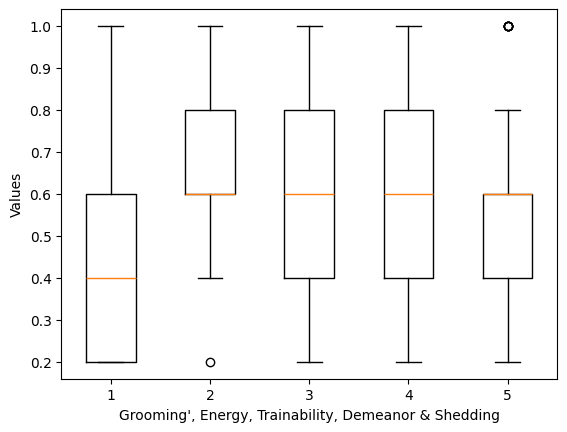

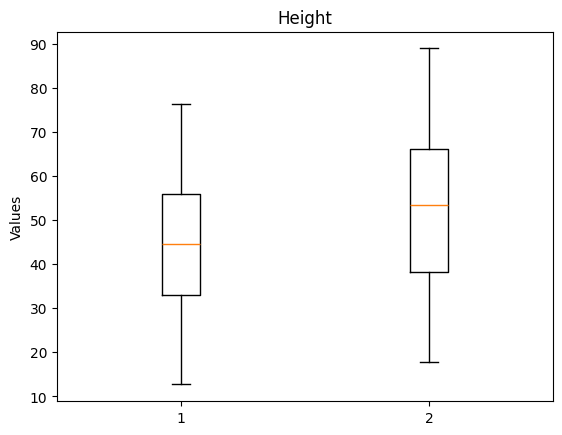

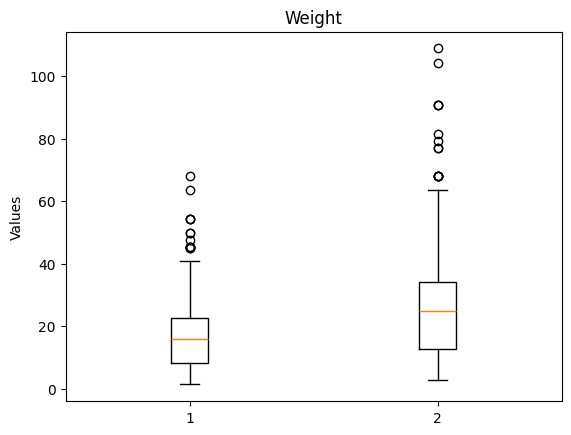

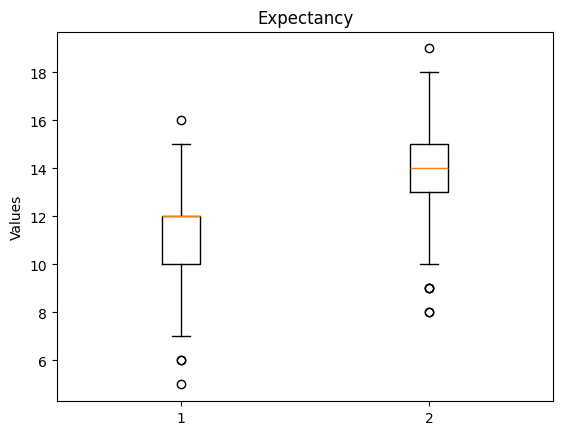

In [8]:
#Boxplot
fig = plt.figure()
plt.ylabel("Values")
plt.xlabel("Grooming', Energy, Trainability, Demeanor & Shedding")
plt.boxplot([data['grooming_frequency_value'].values, data['energy_level_value'].values, data['trainability_value'].values, data['demeanor_value'].values, data['shedding_value'].values])
plt.show()

fig = plt.figure()
plt.ylabel("Values")
plt.title("Height")
plt.boxplot([data['min_height'].values, data['max_height'].values])
plt.show()

fig = plt.figure()
plt.ylabel("Values")
plt.title("Weight")
plt.boxplot([data['min_weight'].values, data['max_weight'].values])
plt.show()

fig = plt.figure()
plt.ylabel("Values")
plt.title("Expectancy")
plt.boxplot([data['min_expectancy'].values, data['max_expectancy'].values])
plt.show()

### Balanceamento

Para lidar com um desequilíbrio na distribuição das classes no conjunto de dados, será feito um oversample aleatório do dataframe, aumentando artificialmente a quantidade de objetos nas classes minoritárias.

In [9]:
ros = RandomOverSampler(random_state=28)
X = data.drop(['group'], axis=1)
y = data.group
X_resampled, y_resampled = ros.fit_resample(X, y)

<Axes: xlabel='group', ylabel='count'>

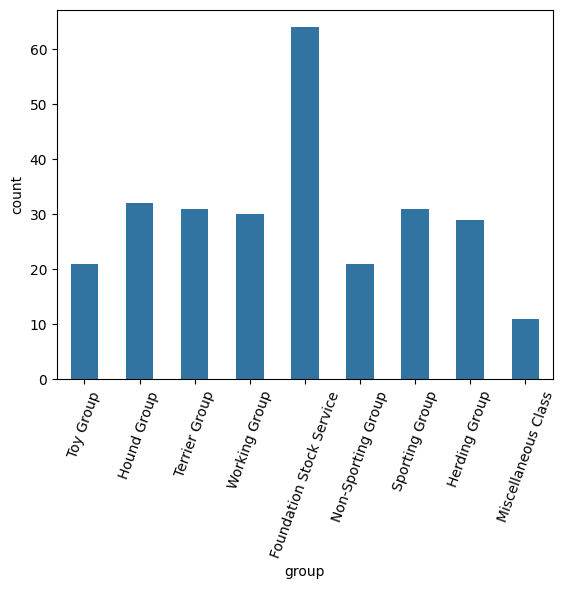

In [10]:
# Objetos de cada classe antes do balanceamento
plt.xticks(rotation=70)
sns.countplot(x=y, width=0.5)

<Axes: xlabel='group', ylabel='count'>

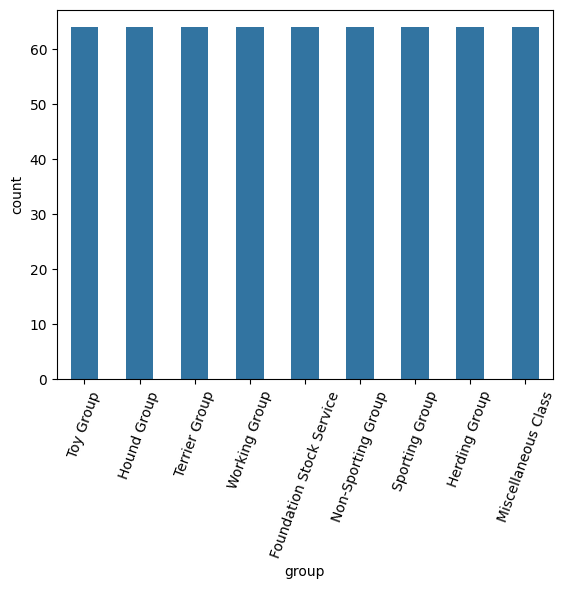

In [11]:
#Após balanceamento
plt.xticks(rotation=70)
sns.countplot(x=y_resampled, width=0.5)

### Redimensionamento de atributos

Foi escolhido o uso da normalização de dados, a fim de colocar todas as variáveis ou características em uma escala comum, geralmente entre 0 e 1, para que possam ser comparadas ou combinadas de forma adequada. É um procedimento importante para algoritmos sensíveis à escala (Exemplo: K-means) ou quando a distância Euclidiana é usada como: medida de similaridade entre amostras ou aplicação de algoritmos de agrupamento.

In [12]:
# Selecionar as colunas numéricas para normalização
numColumns = data.select_dtypes(include='number').columns

# Criar uma instância do StandardScaler
scaler = StandardScaler()

# Aplicar a escala mínima-máxima nas colunas selecionadas
data[numColumns] = scaler.fit_transform(data[numColumns])

### Atributos entrada e saída

O atributo escolhido como saída foi 'group', que indica **[o que significa]**, por meio de **[string-categoria]**.

Escolheu-se 'group' como saída pois quando observado no DataFrame esse era o único atributo com todas as linhas preenchidas. Além disso, essa seria uma escolha popular para se classificar e a anterior possui a mesma estratégia de implementação que as suas semelhantes (trainability, energy, grooming, demeanor).
Os atributos de entrada estão sendo representados por 'X', enquanto o atributo alvo por 'y'.

In [13]:
# Evitar que o atributo alvo não entre com os atributos de entrada
data_v2 = data.copy()
X = data_v2.drop('group', axis=1)

# Definir 'group' como target (saída)
y = data_v2["group"]

### Amostragem

Na divisão em conjuntos de teste e treino, foi decidida a seguinte proporção:

- 80% para o conjunto de treino
- 20% para o conjunto de teste

Essa divisão é realizada baseada na estratificação. Nisso, sem ela pode haver uma distribuição desigual das classes nos conjuntos de treinamento e teste, o que pode levar a um modelo tendencioso ou com desempenho insatisfatório.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, stratify = y_resampled, random_state = 42)

### Redução da dimensionalidade dos dados

Como a quantidade de atributos é relativamente pequena, foi decidido plotar e analisar a correlação entre atributos de entrada, por meio de um heatmap.

Após a análise da correlação entre atributos de entrada, é preciso decidir entre dropar ou fundir atributos redundantes, ou seja, com correlação forte entre si.

Dessa formam, é possível reduzir o número de atributos utilizados pelo modelo, aumentando sua eficiência ao diminuir o custo computacional para aplicá-lo e, possivelmente, melhorar os resultados das aplicações dos modelos, uma vez que os dados irrelevantes e/ou redundantes não serão mais considerados.

In [15]:
X

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
0,-1.484169,-1.461415,-1.205533,-1.198295,0.376330,0.599077,0.869521,0.387830,-0.670719,0.722143,1.960514
1,1.360631,1.005767,0.388118,-0.008461,0.376330,0.599077,1.887267,-1.780069,0.527176,-1.787430,-2.155702
2,1.005031,0.369075,0.388118,0.229506,-0.217875,0.054462,0.869521,-0.696120,-0.670719,1.558667,0.931460
3,1.182831,1.164940,1.129351,1.657306,-0.812080,-0.490154,1.887267,0.387830,0.527176,1.558667,-0.097594
4,1.005031,0.687421,1.314659,0.586456,-0.812080,0.054462,0.869521,0.387830,0.527176,-0.950906,0.931460
...,...,...,...,...,...,...,...,...,...,...,...
272,0.738331,0.687421,0.202810,0.110522,0.376330,0.054462,-1.165971,0.387830,0.527176,-0.114381,-0.097594
273,0.293831,0.687421,-0.427239,-0.008461,0.376330,0.599077,-1.165971,0.387830,0.527176,-0.950906,-0.097594
274,-1.306369,0.369075,-1.094348,-0.127444,0.970535,2.232922,-1.165971,-1.780069,0.527176,-0.114381,-0.097594
275,0.649431,0.369075,0.017501,-0.127444,-0.812080,-1.034769,-0.148225,0.387830,0.527176,-1.787430,-1.126648


### Heatmap de correlação inicial

In [16]:
corr = data_v2.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm') 

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
min_height,1.000000,0.935112,0.825014,0.801873,-0.504807,-0.518707,-0.180190,0.301275,0.191791,-0.042950,-0.237682
max_height,0.935112,1.000000,0.804498,0.817340,-0.471856,-0.508941,-0.238197,0.337785,0.209744,-0.046802,-0.294941
min_weight,0.825014,0.804498,1.000000,0.947405,-0.620639,-0.642030,-0.145633,0.293298,-0.049045,-0.124166,-0.263672
max_weight,0.801873,0.817340,0.947405,1.000000,-0.584678,-0.604172,-0.123884,0.289576,-0.056533,-0.072756,-0.260026
min_expectancy,-0.504807,-0.471856,-0.620639,-0.584678,1.000000,0.720219,0.023683,-0.264410,0.015654,0.108391,0.160551
max_expectancy,-0.518707,-0.508941,-0.642030,-0.604172,0.720219,1.000000,0.133469,-0.383911,0.025379,0.096004,0.154839
grooming_frequency_value,-0.180190,-0.238197,-0.145633,-0.123884,0.023683,0.133469,1.000000,-0.071951,-0.153415,0.094884,0.111356
shedding_value,0.301275,0.337785,0.293298,0.289576,-0.264410,-0.383911,-0.071951,1.000000,0.190538,0.041643,-0.174923
energy_level_value,0.191791,0.209744,-0.049045,-0.056533,0.015654,0.025379,-0.153415,0.190538,1.000000,0.102699,-0.000843
trainability_value,-0.042950,-0.046802,-0.124166,-0.072756,0.108391,0.096004,0.094884,0.041643,0.102699,1.000000,0.332027


Com base no heatmap da correlação, percebe-se uma alta correlação entre:

- min_height e max_height
- min_weight e max_weight
- min_expectancy e max_expectancy
- min_height e min_weight
- max_height e max_weight
- min_height e max_weight
- max_height e min_weight

Por isso, realizou-se uma fusão entre os atributos de altura(height), peso(weight) e expectativa de vida (expectancy), utilizando PCA e gerando novos 3 atributos, eliminando os antigos.

In [17]:
# Médias da altura, peso e expectativa
heightMin = np.array(data_v2['min_height'])
heightMax = np.array(data_v2['max_height'])
aux = np.c_[heightMin - heightMin.mean(), heightMax - heightMax.mean()]
pca = PCA(n_components = 1, copy = True) 
heightNew = pca.fit_transform(aux)
data_v2['height'] = heightNew

weightMin = np.array(data_v2['min_weight'])
weightMax = np.array(data_v2['max_weight'])
aux = np.c_[weightMin - weightMin.mean(), weightMax - weightMax.mean()]
pca = PCA(n_components = 1, copy = True)
weightNew = pca.fit_transform(aux)
data_v2['weight'] = weightNew

expectancyMin = np.array(data_v2['min_expectancy'])
expectancyMax = np.array(data_v2['max_expectancy'])
aux = np.c_[expectancyMin - expectancyMin.mean(), expectancyMax - expectancyMax.mean()]
pca = PCA(n_components = 1, copy = True) 
expectancyNew = pca.fit_transform(aux)
data_v2['expectancy'] = expectancyNew

#Médias da altura e peso
meanHeight = (data_v2['min_height'] + data_v2['max_height'])/2
meanWeight = (data_v2['min_weight'] + data_v2['max_weight'])/2

#Excluiu as colunas relacionadas a peso, altura e expectativa e adiciona suas respectivas médias
data_v2 = data_v2.drop(columns=["min_height", "max_height", "min_weight", "max_weight", "min_expectancy", "max_expectancy"])

corr = data_v2.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value,height,weight,expectancy
grooming_frequency_value,1.000000,-0.071951,-0.153415,0.094884,0.111356,0.212672,-0.136566,-0.084725
shedding_value,-0.071951,1.000000,0.190538,0.041643,-0.174923,-0.324843,0.295347,0.349529
energy_level_value,-0.153415,0.190538,1.000000,0.102699,-0.000843,-0.204106,-0.053497,-0.022122
trainability_value,0.094884,0.041643,0.102699,1.000000,0.332027,0.045622,-0.099782,-0.110195
demeanor_value,0.111356,-0.174923,-0.000843,0.332027,1.000000,0.270740,-0.265362,-0.170036
height,0.212672,-0.324843,-0.204106,0.045622,0.270740,1.000000,-0.836761,-0.549275
weight,-0.136566,0.295347,-0.053497,-0.099782,-0.265362,-0.836761,1.000000,0.669708
expectancy,-0.084725,0.349529,-0.022122,-0.110195,-0.170036,-0.549275,0.669708,1.000000


Tendo em vista a correlação alta entre peso e altura, faz-se necessária a unificação em um atributo, que será o IMC, sendo seu conteúdo equivalente ao peso/altura de cada linha

Após isso, os atributos são normalizados.

In [18]:
meanImc = (meanHeight * meanHeight) / (meanWeight * 100)

#height e weight estão correlacionadas
data_v2['imc_metric'] = meanImc
data_v2 = data_v2.drop(columns=['height', 'weight'])

#Novos atibutos
scaler = MinMaxScaler()
data_v2['expectancy'] = scaler.fit_transform(data_v2['expectancy'].to_numpy().reshape(-1,1))
data_v2['imc_metric'] = scaler.fit_transform(data_v2['imc_metric'].to_numpy().reshape(-1,1))

corr = data_v2.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value,expectancy,imc_metric
grooming_frequency_value,1.000000,-0.071951,-0.153415,0.094884,0.111356,-0.084725,-0.091111
shedding_value,-0.071951,1.000000,0.190538,0.041643,-0.174923,0.349529,0.074543
energy_level_value,-0.153415,0.190538,1.000000,0.102699,-0.000843,-0.022122,0.091830
trainability_value,0.094884,0.041643,0.102699,1.000000,0.332027,-0.110195,-0.005798
demeanor_value,0.111356,-0.174923,-0.000843,0.332027,1.000000,-0.170036,-0.046660
expectancy,-0.084725,0.349529,-0.022122,-0.110195,-0.170036,1.000000,0.048948
imc_metric,-0.091111,0.074543,0.091830,-0.005798,-0.046660,0.048948,1.000000


In [19]:
print("Dimensão inicial: ", data.shape)
print("Dimensão final: ", data_v2.shape)

Dimensão inicial:  (270, 12)
Dimensão final:  (270, 8)


In [20]:
X = data_v2.drop(['group'], axis=1)

#Definir 'group' como target (saída)
y = data_v2.group

X_resampled, y_resampled = ros.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, stratify = y_resampled, random_state = 42)

X = np.array(X)
y = np.array(y)

## Aprendizagem Supervisionada

Métodos utilizados:

    - Decision Tree
    - Naive-Bayes
    - MLP

### Decision Tree

A árvore de decisão tornou-se a primeira escolha devido a ser um algoritmo de aprendizado de máquina amplamente utilizado em tarefas de classificação e regressão. Baseia suas decisões em um conjunto de regras e atributos de entrada. Este modelo é extremamente popular devido a vantagens como: capacidade de lidar com dados mistos, rapidez no treinamento e previsão, e robustez a outliers.

Nesse procedimento, o hiperparâmetro alterado para teste foi o '**Splitter**', sendo a estratégia usada para escolher a divisão em cada nó. As estratégias suportadas são “**best**” para escolher a melhor divisão e “**random**” para escolher a melhor divisão aleatória. Para testes, inclui-se a modificação do hiperparâmetro '**Max_depth**' (A profundidade máxima da árvore), com intuito de mostrar se há uma maior variedade de resultados.

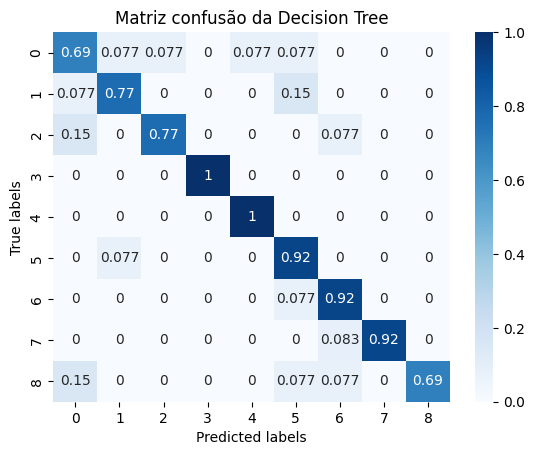

Acurácia do modelo antes da aplicação do Stratified K-Fold: 85.34%
F1-Score do modelo antes da aplicação do Stratified K-Fold: 85.41%


In [21]:
dt_classifier = DecisionTreeClassifier(random_state=28)

dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')

confusion = confusion_matrix(y_test, y_pred)

normalized_confusion = confusion / confusion.sum(axis=1, keepdims=True)

xlabel = np.unique(list(y_test))
sns.heatmap(normalized_confusion, annot=True, cmap="Blues", label=xlabel)
plt.title('Matriz confusão da Decision Tree')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

print('Acurácia do modelo antes da aplicação do Stratified K-Fold: {:.2f}%'.format(acc * 100))
print('F1-Score do modelo antes da aplicação do Stratified K-Fold: {:.2f}%'.format(f1 * 100))

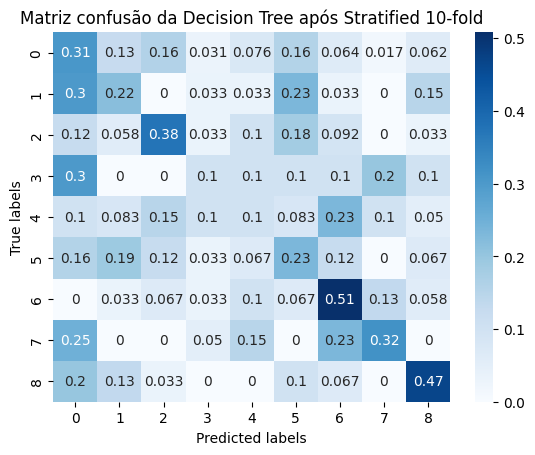

Média da Acurácia do modelo depois do skf: 31.48%
Média do F1-Score do modelo depois do skf: 30.69%


In [22]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=28)

acc_list = []
f1_list = []
confusion_list = []

for i_train, i_test in skf.split(X, y):

    X_train, X_test = X[i_train], X[i_test]
    y_train, y_test = y[i_train], y[i_test]

    dt_classifier.fit(X_train, y_train)

    y_pred = dt_classifier.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)

    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_list.append(f1)

    confusion = confusion_matrix(y_test, y_pred)
    confusion_list.append(confusion)

normalized_confusion = [confusion / confusion.sum(axis=1, keepdims=True) for confusion in confusion_list]

mean_normalized_confusion = np.mean(normalized_confusion, axis=0)

sns.heatmap(mean_normalized_confusion, annot=True, cmap="Blues", label=xlabel)
plt.title('Matriz confusão da Decision Tree após Stratified 10-fold')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

# exibir a acuracia e o f1-score
print('Média da Acurácia do modelo depois do skf: {:.2f}%'.format(np.mean(acc_list)*100))
print('Média do F1-Score do modelo depois do skf: {:.2f}%'.format(np.mean(f1_list)*100))

Após o uso da validação estratificada k-fold, os valores de acurácia e f1-score caíram drasticamente, isso pode se dar pelo fato da aplicação do SKF indicar a variância do modelo, ou seja, a sensibilidade do modelo às flutuações nos dados de treinamento, por conta das diferentes estruturas de árvore criadas para cada treinamento.

### Naive-Bayes

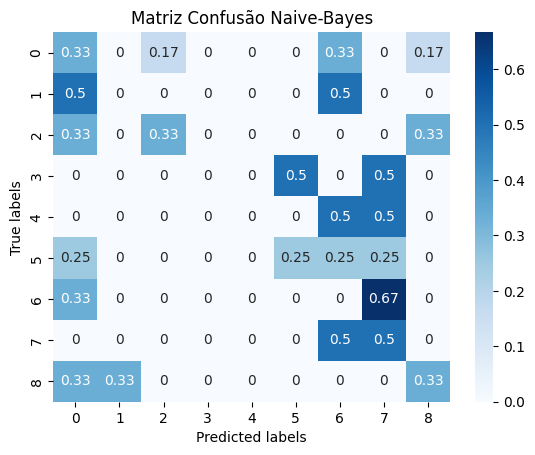

Acurácia do modelo antes do skf: 22.22%
F1-Score do modelo antes do skf: 21.78%


In [23]:
# Dados de entrada
X = np.array(X)
y = np.array(y)

# Inicializar o classificador Naive Bayes Gaussiano
nb_classifier = GaussianNB()

nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')

confusion = confusion_matrix(y_test, y_pred)
norm_conf_matrix = confusion / confusion.sum(axis=1, keepdims=True)


sns.heatmap(norm_conf_matrix, annot=True, cmap='Blues', label=xlabel)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz Confusão Naive-Bayes')
plt.show()

# Imprimir a acurácia e o f1-score
print('Acurácia do modelo antes do skf: {:.2f}%'.format(acc * 100))
print('F1-Score do modelo antes do skf: {:.2f}%'.format(f1 * 100))


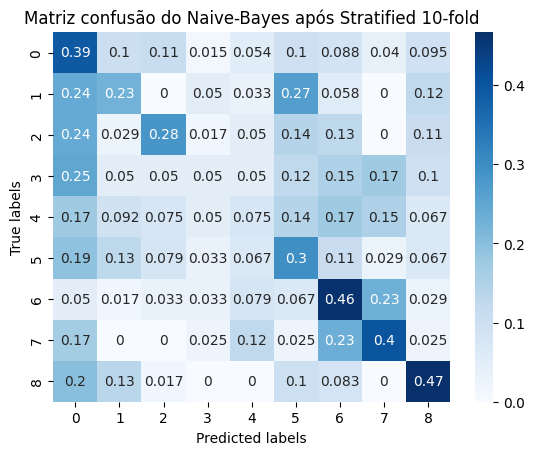

Média da Acurácia do modelo depois do skf: 32.96%
Média do F1-Score do modelo depois do skf: 31.30%


In [24]:
for i_train, i_test in skf.split(X, y):

    X_train, X_test = X[i_train], X[i_test]
    y_train, y_test = y[i_train], y[i_test]

    nb_classifier.fit(X_train, y_train)

    y_pred = nb_classifier.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)

    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_list.append(f1)

    confusion = confusion_matrix(y_test, y_pred)
    confusion_list.append(confusion)

normalized_confusion = [confusion / confusion.sum(axis=1, keepdims=True) for confusion in confusion_list]

mean_normalized_confusion = np.mean(normalized_confusion, axis=0)

sns.heatmap(mean_normalized_confusion, annot=True, cmap="Blues", label=xlabel)
plt.title('Matriz confusão do Naive-Bayes após Stratified 10-fold')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

# exibir a acuracia e o f1-score
print('Média da Acurácia do modelo depois do skf: {:.2f}%'.format(np.mean(acc_list)*100))
print('Média do F1-Score do modelo depois do skf: {:.2f}%'.format(np.mean(f1_list)*100))

Após o uso da validação estratificada 10-fold no modelo de **Naive-Bayes**, os valores de **acurácia** e **f1-score** subiram. Isso ocorreu, muito provavelmente, por conta do fornecimento de amostras mais representativas para treinamento e teste, o que é crucial para modelos de Naive-Bayes, que são caracteristicamente probabilísticos.

### MLP

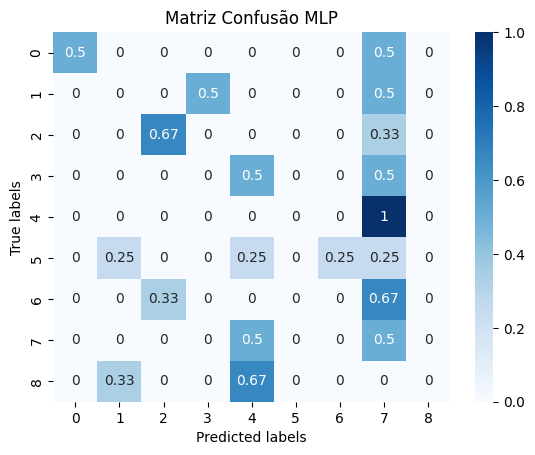

Acurácia do modelo antes do skf: 22.22%
F1-Score do modelo antes do skf: 23.28%


In [25]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

mlp_classifier = MLPClassifier(hidden_layer_sizes=(600, 300), max_iter=800, random_state=28)

mlp_classifier.fit(X_train_scaled, y_train)

y_pred = mlp_classifier.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')

confusion = confusion_matrix(y_test, y_pred)

normalized_confusion = confusion / confusion.sum(axis=1, keepdims=True)

sns.heatmap(normalized_confusion, annot=True, cmap='Blues', label = xlabel)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz Confusão MLP')
plt.show()

print('Acurácia do modelo antes do skf: {:.2f}%'.format(acc * 100))
print('F1-Score do modelo antes do skf: {:.2f}%'.format(f1 * 100))


c:\Users\guilherme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


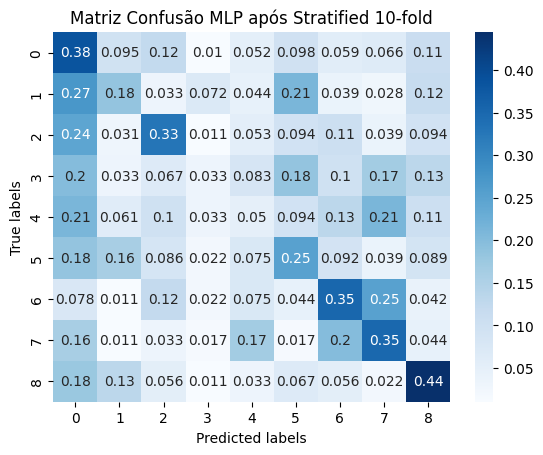

Média da Acurácia do modelo depois do skf: 30.12%
Média do F1-Score do modelo depois do skf: 27.75%


In [26]:
for train_i, test_i in skf.split(X, y):

    X_train, X_test = X[train_i], X[test_i]
    y_train, y_test = y[train_i], y[test_i]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    # Treinar o modelo com os dados de treinamento
    mlp_classifier.fit(X_train_scaled, y_train)

    y_pred = mlp_classifier.predict(X_test_scaled)

    # Calcular a precisão do modelo
    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)

    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_list.append(f1)

    confusion = confusion_matrix(y_test, y_pred)
    confusion_list.append(confusion)

confusion_normalized = [confusion / confusion.sum(axis=1, keepdims=True) for confusion in confusion_list]

mean_confusion_normalized = np.mean(confusion_normalized, axis=0)

sns.heatmap(mean_confusion_normalized, annot=True, cmap='Blues', label = xlabel)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz Confusão MLP após Stratified 10-fold')
plt.show()

print('Média da Acurácia do modelo depois do skf: {:.2f}%'.format(np.mean(acc_list)*100))
print('Média do F1-Score do modelo depois do skf: {:.2f}%'.format(np.mean(f1_list)*100))

É possível ver que, após o uso da validação estratificada 10-fold no modelo MLP, os valores tanto de acurácia quanto de f1-score subiram. Muito provavelmente por conta que o modelo é treinado em diferentes subconjuntos do conjunto de dados original. Com várias iterações de treinamento, o modelo tem mais dados para trabalhar e o aprendizado é mais rico.

### Considerações finais - Aprendizado supervisionado

Após análise de todas as matrizes de confusão, é possível concluir, claramente, que o modelo que apresentou melhor desempenho foi o de Árvore de Decisão, sem o uso da validação estratificada 10-fold.

## Aprendizado não-supervisionado

Para o aprendizado não supervisionado, serão utilizados 2 modelos:

- K-means
- Agrupamento Hierárquico

Como métricas de avaliação, serão usadas:

- Cluster
- Silhouette Score

In [27]:
X, _ = datasets.make_blobs(n_samples=300, centers=4, cluster_std=1.0, random_state=28)

<function matplotlib.pyplot.show(close=None, block=None)>

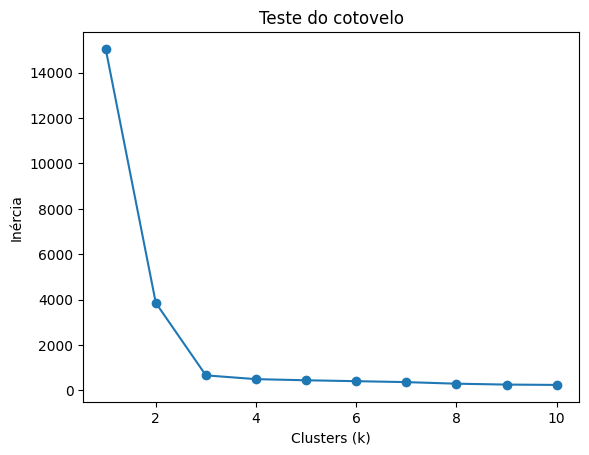

In [28]:
k_values = range(1,11)
inertia = []

for k in k_values:
    kmeans = KMeans(n_init='auto', n_clusters=k, random_state=28)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, '-o')
plt.xlabel('Clusters (k)')
plt.ylabel('Inércia')
plt.title('Teste do cotovelo')
plt.show

Silhouette Score do modelo K-means: 0.6041519109186801


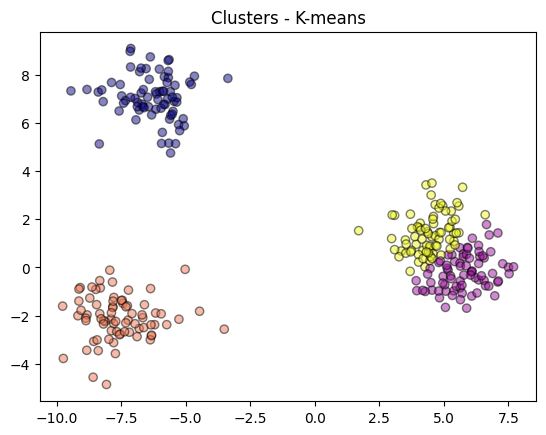

In [29]:
kmeans = KMeans(n_init='auto', n_clusters=4, random_state=28)
kmeans.fit(X)

silhouette = silhouette_score(X, kmeans.labels_)

print(f'Silhouette Score do modelo K-means: {silhouette}')
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='plasma', alpha=0.5, edgecolors='k')
plt.title('Clusters - K-means')
plt.show()

### Clustering Hierárquico

Silhouette Score do modelo de Hierarchical Clustering (Ward): 0.5738835199122847


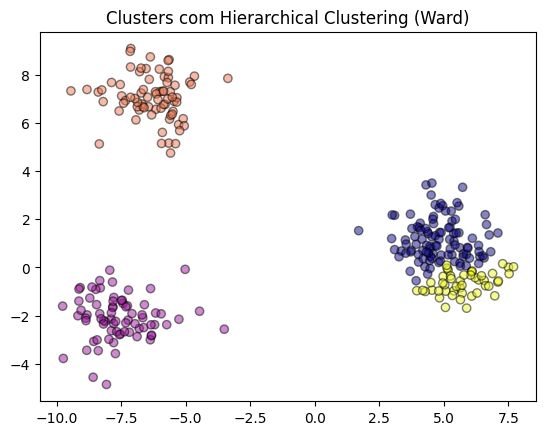

Silhouette Score para Hierarchical (Complete): 0.7063116479922131


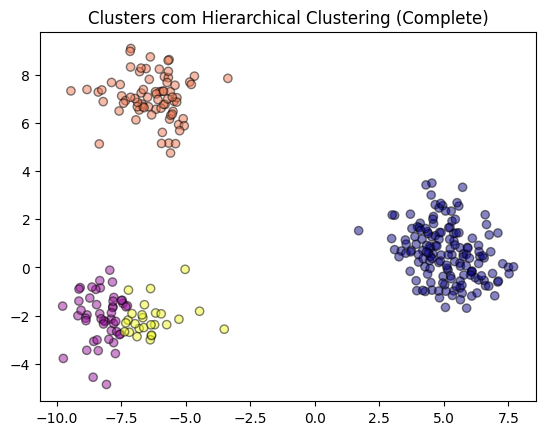

In [30]:
aggc_ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
aggc_complete = AgglomerativeClustering(n_clusters=4, linkage='complete')

aggc_ward.fit(X)
aggc_complete.fit(X)

silhouette_w = silhouette_score(X, aggc_ward.labels_)
silhouette_c = silhouette_score(X, aggc_complete.labels_)

print(f"Silhouette Score do modelo de Hierarchical Clustering (Ward): {silhouette_w}")
plt.scatter(X[:, 0], X[:, 1], c=aggc_ward.labels_, cmap='plasma', alpha=0.5, edgecolors='k')
plt.title('Clusters com Hierarchical Clustering (Ward)')
plt.show()

print(f"Silhouette Score para Hierarchical (Complete): {silhouette_c}")
plt.scatter(X[:, 0], X[:, 1], c=aggc_complete.labels_, cmap='plasma', alpha=0.5, edgecolors='k')
plt.title('Clusters com Hierarchical Clustering (Complete)')
plt.show()

### Métrica de avaliação própria

Os modelos de aprendizado não-supervisionado aplicados serão avaliados a partir de coeficientes de separação e compactação dos clusters.

In [31]:
def cluster_compaction(X, labels):
    """ Mede a média da distância intra-cluster """
    n_clusters = len(np.unique(labels))
    compactness = 0
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        centroid = np.mean(cluster_points, axis=0)
        compactness += np.mean(np.linalg.norm(cluster_points - centroid, axis=1))
    return compactness / n_clusters

def cluster_separation(X, labels):
    """ Mede a distância média inter-cluster """
    n_clusters = len(np.unique(labels))
    cluster_centroids = np.array([np.mean(X[labels == i], axis=0) for i in range(n_clusters)])
    separation = 0
    count = 0
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            separation += np.linalg.norm(cluster_centroids[i] - cluster_centroids[j])
            count += 1
    return separation / count

In [32]:
compactness_kmeans = cluster_compaction(X, kmeans.labels_)
compactness_ward = cluster_compaction(X, aggc_ward.labels_)
compactness_complete = cluster_compaction(X, aggc_complete.labels_)

print(f"Coeficiente de Compactação para K-means: {compactness_kmeans}")
print(f"Coeficiente de Compactação para Hierarchical (Ward): {compactness_ward}")
print(f"Coeficiente de Compactação para Hierarchical (Complete): {compactness_complete}")

Coeficiente de Compactação para K-means: 1.12510118737515
Coeficiente de Compactação para Hierarchical (Ward): 1.1368208621251852
Coeficiente de Compactação para Hierarchical (Complete): 1.1389215823566023


In [33]:
separation_kmeans = cluster_separation(X, kmeans.labels_)
separation_ward = cluster_separation(X, aggc_ward.labels_)
separation_complete = cluster_separation(X, aggc_complete.labels_)

print(f"Coeficiente de Separação para K-means: {separation_kmeans}")
print(f"Coeficiente de Separação para Hierarchical (Ward): {separation_ward}")
print(f"Coeficiente de Separação para Hierarchical (Complete): {separation_complete}")

Coeficiente de Separação para K-means: 10.599674949260622
Coeficiente de Separação para Hierarchical (Ward): 10.744761678065338
Coeficiente de Separação para Hierarchical (Complete): 9.825901857669512
